In [1]:
import pandas as pd

naslib_path = '../data/'
benchmark = 'zc_nasbench201'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores

search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [3]:
dataset = 'ImageNet16-120'
data = dfs[dataset]

In [5]:
import json
with open('../data/meta.json', 'r') as f:
    meta = json.load(f)
nb201_unique = [v['nb201-string'] for k, v in meta['ids'].items() if k == v['isomorph']]
nb201_unique[0]

'|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|'

In [6]:
from zc_combine.features.conversions import keep_only_isomorpic_nb201

data = keep_only_isomorpic_nb201(data, meta)

In [4]:
from zc_combine.fixes.operations import get_ops_edges_nb201
from zc_combine.fixes.utils import nb201_zero_out_unreachable

_, edge_map = get_ops_edges_nb201()
nb201_zero_out_unreachable(data, edge_map)

In [5]:
print(len(data))
data = data[data['net'] == data['new_net']]
print(len(data))

15625
9445


In [9]:
from zc_combine.features.conversions import nb201_to_graph

nets = {i: nb201_to_graph(data.loc[i]) for i in data.index}

In [10]:
import json

with open('../zc_combine/configs/nb201_first.json', 'r') as f:
    cfg = json.load(f)

In [11]:
from zc_combine.features.nasbench201 import feature_func_dict
from zc_combine.features.dataset import get_feature_dataset

feature_dataset = get_feature_dataset(nets, cfg, feature_func_dict)
feature_dataset.keys()

dict_keys(['op_count', 'min_path_len', 'max_op_on_path', 'node_degree'])

In [12]:
features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
dataset = pd.concat([feature_dataset[f] for f in features], axis=1)
dataset['val_accs'] = data['val_accs']
dataset

,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[1],"min_path_len_banned_[0, 1]","min_path_len_banned_[0, 1, 4]","min_path_len_banned_[1, 4]",max_op_on_path_allowed_[0],...,"node_degree_allowed_[0, 2]_avg_out","node_degree_allowed_[0, 3]_in_degree","node_degree_allowed_[0, 3]_out_degree","node_degree_allowed_[0, 3]_avg_in","node_degree_allowed_[0, 3]_avg_out","node_degree_allowed_[0, 2, 3]_in_degree","node_degree_allowed_[0, 2, 3]_out_degree","node_degree_allowed_[0, 2, 3]_avg_in","node_degree_allowed_[0, 2, 3]_avg_out",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,2,2,1,1,1,1,1,...,0.25,2,2,0.75,0.75,2,2,0.75,0.75,32.700000
1,2,0,2,1,1,1,2,2,1,1,...,1.00,1,2,0.75,0.75,2,3,1.25,1.25,44.233333
3,2,1,2,1,0,1,1,1,1,1,...,1.00,2,1,0.75,0.75,3,3,1.25,1.25,40.600000
7,0,1,0,4,1,1,1,1,1,0,...,0.00,1,3,1.00,1.00,1,3,1.00,1.00,37.100000
8,0,1,2,3,0,1,1,1,1,0,...,0.50,1,1,0.75,0.75,2,3,1.25,1.25,42.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15617,1,1,2,1,1,1,1,2,2,1,...,0.75,0,2,0.50,0.50,1,2,1.00,1.00,40.400000
15618,2,0,2,1,1,1,1,1,1,1,...,1.00,1,2,0.75,0.75,3,3,1.25,1.25,39.300000
15620,1,1,1,1,2,2,2,5,2,1,...,0.50,0,2,0.50,0.50,1,2,0.75,0.75,36.433333


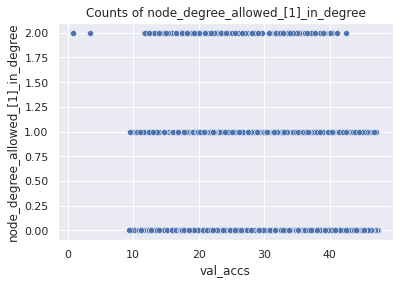

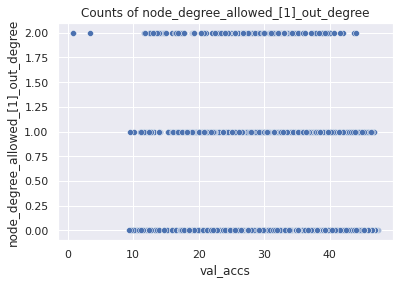

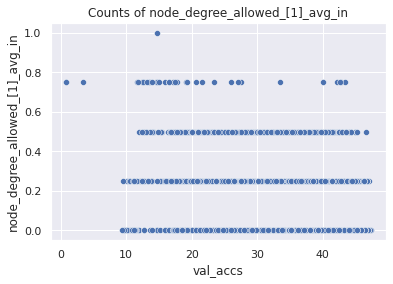

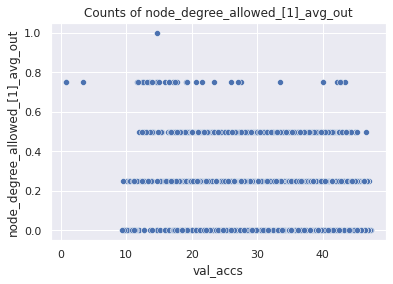

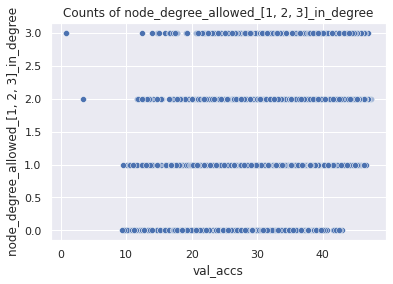

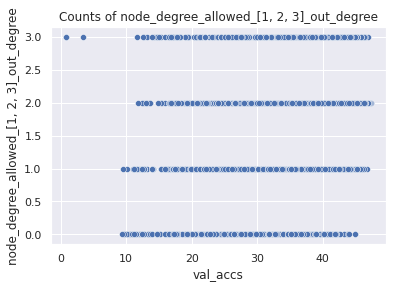

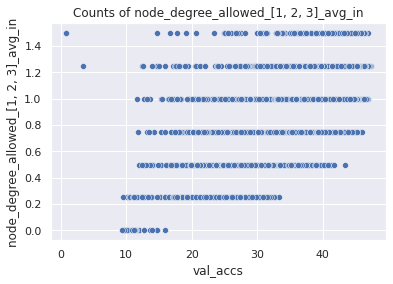

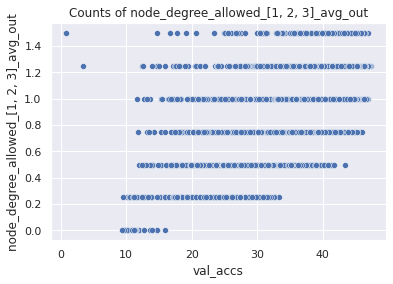

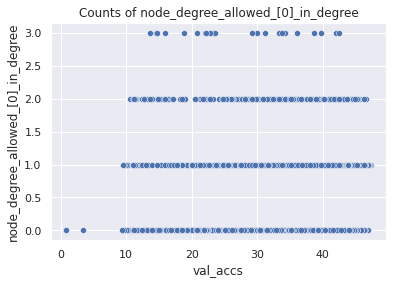

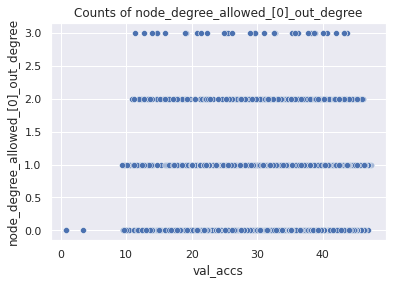

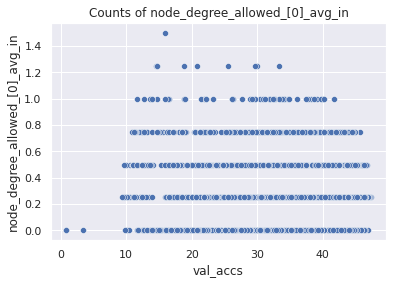

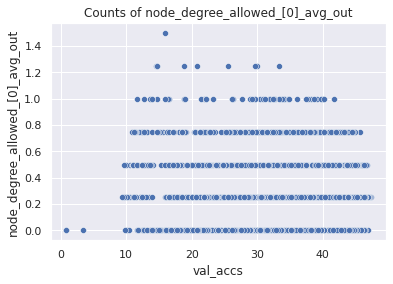

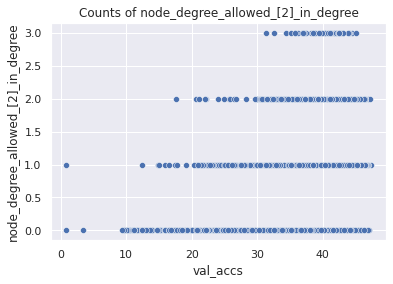

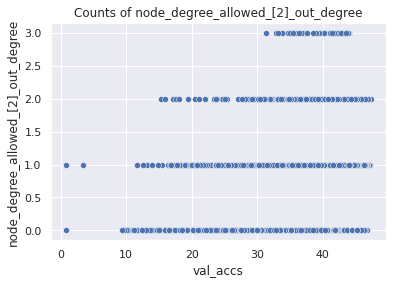

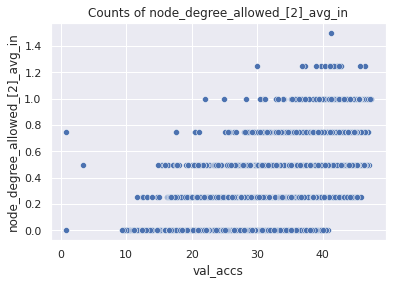

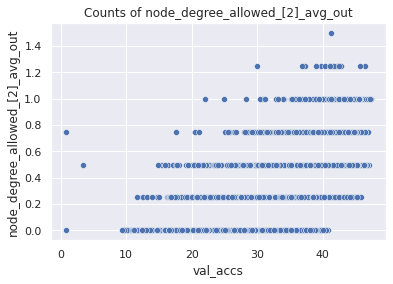

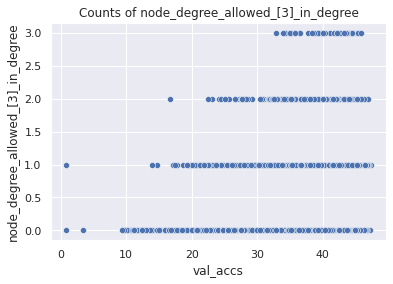

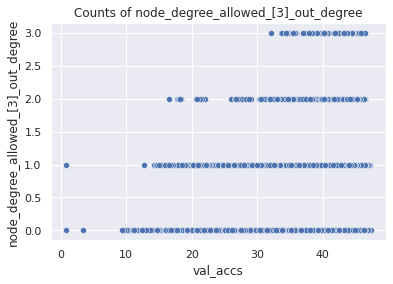

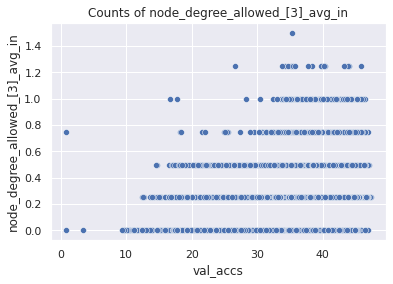

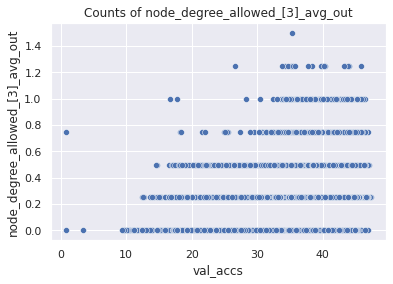

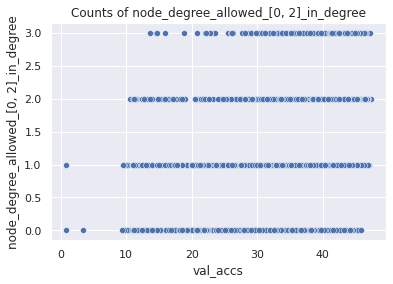

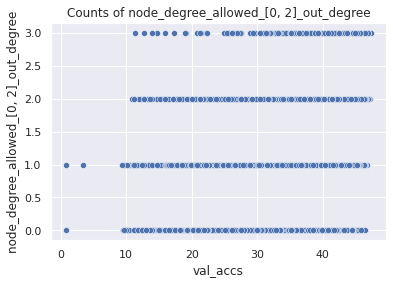

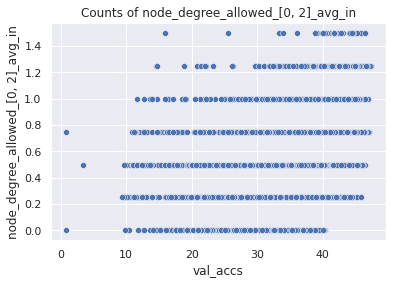

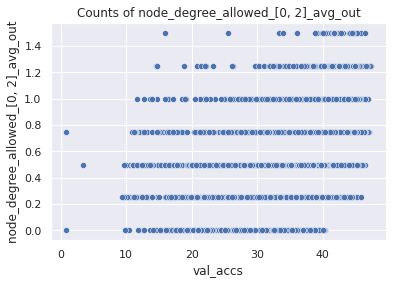

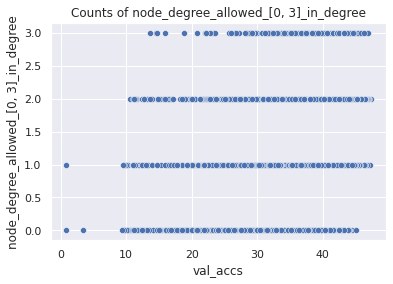

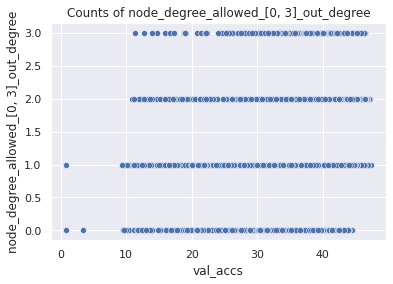

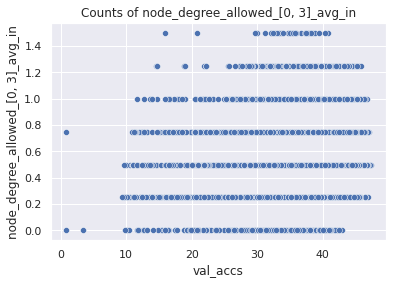

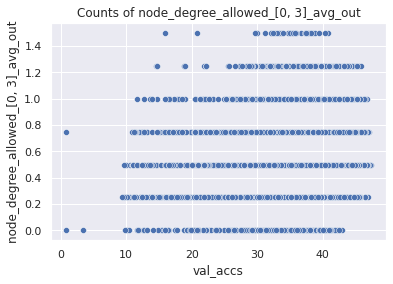

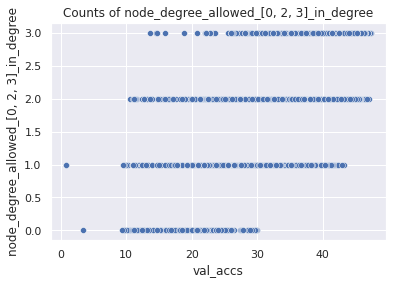

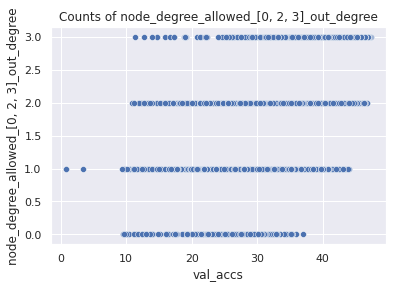

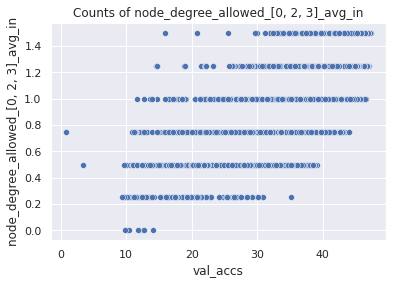

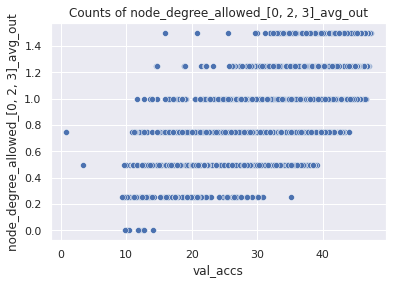

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = feature_dataset['node_degree'].copy()
plot_df['val_accs'] = data['val_accs']

import os
#os.mkdir('tmp')

for c in plot_df.columns:
    if c == 'val_accs':
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [14]:
edges = list(edge_map.keys())

dataset_raw = {i: [n[1][e] for e in edges] for i, n in nets.items()}
dataset_raw[0]

[4, 0, 3, 1, 4, 3]

In [15]:
draw = [{'idx': i, **{f'op_{j}': v for j, v in enumerate(o)}} for i, o in dataset_raw.items()]
draw = pd.DataFrame(draw).set_index('idx')

In [16]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(feature_dfs, proxy_df, features, cols):
    feat_dfs = [feature_dfs[f] for f in features]
    prox_df = proxy_df[cols]

    res_data = pd.concat([*feat_dfs, prox_df], axis=1)

    y = proxy_df['val_accs'].loc[res_data.index]
    if 'val_accs' in res_data:
        res_data.drop(columns=['val_accs'], inplace=True)

    return res_data, y

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
full_data, full_y = get_dataset(feature_dataset, data, features, ['flops', 'params'])
print(full_data.shape)
full_data

(6144, 50)


,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[1],"min_path_len_banned_[0, 1]","min_path_len_banned_[0, 1, 4]","min_path_len_banned_[1, 4]",max_op_on_path_allowed_[0],...,"node_degree_allowed_[0, 3]_in_degree","node_degree_allowed_[0, 3]_out_degree","node_degree_allowed_[0, 3]_avg_in","node_degree_allowed_[0, 3]_avg_out","node_degree_allowed_[0, 2, 3]_in_degree","node_degree_allowed_[0, 2, 3]_out_degree","node_degree_allowed_[0, 2, 3]_avg_in","node_degree_allowed_[0, 2, 3]_avg_out",flops,params
0,1,1,0,2,2,1,1,1,1,1,...,2,2,0.75,0.75,2,2,0.75,0.75,4.820032,0.136456
1,2,0,2,1,1,1,2,2,1,1,...,1,2,0.75,0.75,2,3,1.25,1.25,21.316672,0.594536
3,2,1,2,1,0,1,1,1,1,1,...,2,1,0.75,0.75,3,3,1.25,1.25,20.994112,0.594536
7,0,1,0,4,1,1,1,1,1,0,...,1,3,1.00,1.00,1,3,1.00,1.00,6.678592,0.192456
8,0,1,2,3,0,1,1,1,1,0,...,1,1,0.75,0.75,2,3,1.25,1.25,23.175232,0.650536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15617,1,1,2,1,1,1,1,2,2,1,...,0,2,0.50,0.50,1,2,1.00,1.00,21.316672,0.594536
15618,2,0,2,1,1,1,1,1,1,1,...,1,2,0.75,0.75,3,3,1.25,1.25,21.316672,0.594536
15620,1,1,1,1,2,2,2,5,2,1,...,0,2,0.50,0.50,1,2,0.75,0.75,12.684352,0.351496
15622,0,0,2,3,1,1,1,1,1,0,...,2,1,0.75,0.75,3,2,1.25,1.25,23.497792,0.650536


In [17]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def get_splits(fd, fy, train_size=100, seed=42):
    return train_test_split(fd, fy, random_state=seed, train_size=train_size)

def eval_rf(trx, tex, tryy, tey, n_times=1, random_state=43):
    res = {'score': [], 'tau': [], 'corr': []}
    rfs = []
    for i in range(n_times):
        rf = RandomForestRegressor(random_state=random_state + i, n_estimators=100)
        rf.fit(trx, tryy)
        res['score'].append(rf.score(tex, tey))

        preds = rf.predict(tex)
        res['tau'].append(kendalltau(preds, tey)[0])
        res['corr'].append(spearmanr(preds, tey)[0])
        rfs.append(rf)

    return rfs, res

def print_means(res):
    print(", ".join([f"{k}: {np.mean(v)}" for k, v in res.items()]))

In [18]:
import numpy as np

skip_dis = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
seed = 44
for ts in [100, 200, 1000]:
    if skip_dis:
        break

    print(f"Train size {ts}")
    for prox in proxy_cols:
        for include_fp in [True, False]:
            if prox in ['flops', 'params']:
                continue
            print(prox, "" if include_fp else " no fp")

            plist = ['flops', 'params', prox] if include_fp else [prox]
            fd, fy = get_dataset(feature_dataset, data, features, plist)
            data_splits = get_splits(fd, fy, train_size=ts, seed=seed)

            _, res = eval_rf(*data_splits, n_times=5)
            print_means(res)
            print()

In [27]:
ts = 100
seed = 42

all_proxies = False
prox_to_include = []
#prox_to_include = ['jacov', 'fisher']
with_features = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
feat_list = features if with_features else []

# proxies to add to data
def_proxlist = ['params', 'flops'] if prox_to_include is None else ['params', 'flops', *prox_to_include]
prox_list = proxy_cols if all_proxies else def_proxlist

fd, fy = get_dataset(feature_dataset, data, feat_list, prox_list)
train_X, test_X, train_y, test_y = get_splits(fd, fy, train_size=ts, seed=seed)

rfs, res = eval_rf(train_X, test_X, train_y, test_y, n_times=5)
print_means(res)
rf_fitted = rfs[0]
preds = rf_fitted.predict(fd)
preds

score: 0.8036882527860378, tau: 0.7123618734232144, corr: 0.8918937397977265


array([36.3426666 , 38.61133327, 42.24966658, ..., 32.16499995,
       44.12899994, 33.44666661])

In [28]:
trainpreds = rf_fitted.predict(train_X)

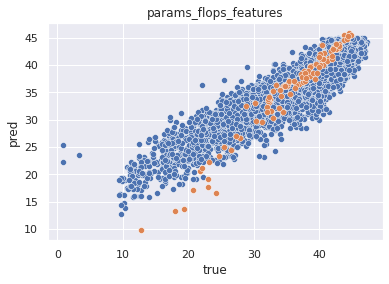

In [29]:
sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': fy}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)

plt_name = f"{'all_proxies' if all_proxies else 'params_flops'}_{'features' if with_features else 'no_features'}"
plt.title(plt_name)
#plt.savefig(f"tmp/{plt_name}.png")
plt.show()

In [30]:
from sklearn.decomposition import PCA

pca_data = fd#data[proxy_cols]
pca = PCA(n_components=2)
pca.fit(train_X)
pca_data = pca.transform(pca_data)
#pca_data = pca.fit_transform(pca_data)
pca_data

array([[-11.28832217,  -2.50238711],
       [  5.42885788,  -0.80917061],
       [  5.2377269 ,  -1.82451223],
       ...,
       [ -3.65762046,   2.30528884],
       [  7.70376461,  -2.1258502 ],
       [ -3.98754809,   1.94779144]])

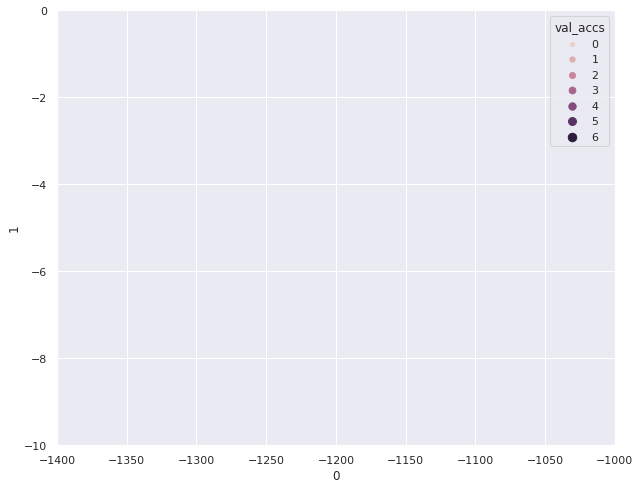

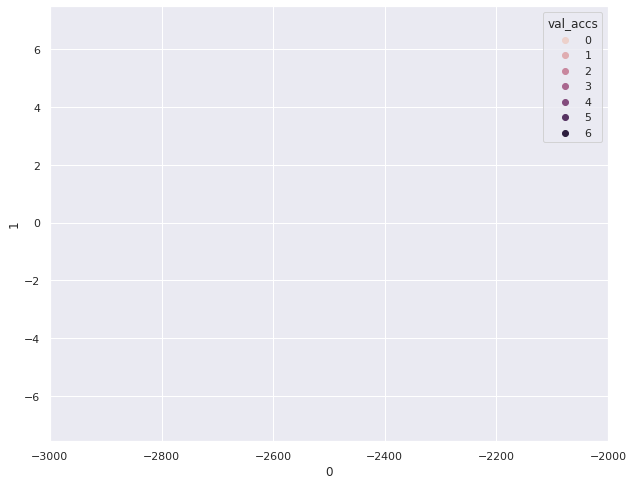

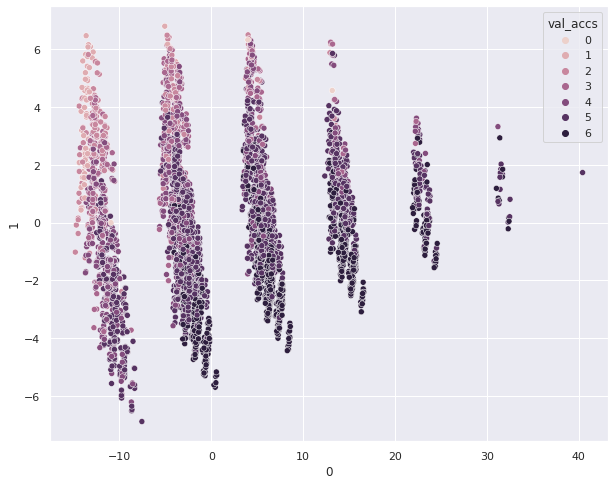

In [31]:
val_accss = data['val_accs'].to_numpy()
plot_dd = pd.DataFrame(pca_data)
plot_dd['val_accs'] = val_accss // 7


plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs', size='val_accs')
plt.xlim(-1400, -1000)
#plt.xlim(-1392, -1387)
plt.ylim(-10, 0)
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
plt.xlim(-3000, -2000)
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
#plt.xlim(-2000, 5000)
plt.show()

In [45]:
pd.DataFrame(pca.components_, columns=fd.columns).iloc[0].to_numpy()

array([-4.19474096e-02, -3.73504544e-03,  1.12566241e-01, -2.41187768e-02,
       -4.27650093e-02, -2.18208253e-03, -2.69689187e-02, -1.08070042e-01,
       -3.68418216e-02, -2.55990693e-02,  3.71136133e-02,  2.53894407e-02,
       -3.23370691e-02,  4.25395994e-02,  6.55434714e-02, -1.65035021e-02,
       -6.62808626e-03,  5.04098812e-03, -9.33761359e-04, -9.33761359e-04,
        4.11210545e-02,  5.06521370e-02,  2.11781047e-02,  2.11781047e-02,
       -2.52034800e-02, -2.43763681e-02, -1.04868524e-02, -1.04868524e-02,
        6.47579157e-02,  4.56676400e-02,  2.81415603e-02,  2.81415603e-02,
       -1.70087749e-02, -5.64911129e-05, -6.02969419e-03, -6.02969419e-03,
        3.95544357e-02,  2.12912720e-02,  1.76547079e-02,  1.76547079e-02,
       -4.22122550e-02, -2.44328592e-02, -1.65165466e-02, -1.65165466e-02,
        2.25456608e-02,  2.12347809e-02,  1.16250137e-02,  1.16250137e-02,
        2.66827735e-02,  9.67919927e-01])

In [89]:
comps = np.abs(pca.components_[0])
cidx = np.argsort(comps)
fd.columns[cidx][::-1]

Index(['flops', 'op_count_2', 'min_path_len_banned_[0, 1, 4]',
       'max_op_on_path_allowed_[2]', 'node_degree_allowed_[2]_in_degree',
       'node_degree_allowed_[2]_out_degree', 'op_count_4',
       'node_degree_allowed_[0, 2]_in_degree',
       'node_degree_allowed_[0, 2]_out_degree',
       'max_op_on_path_allowed_[0, 2]',
       'node_degree_allowed_[1, 2, 3]_in_degree',
       'node_degree_allowed_[1, 2, 3]_out_degree',
       'max_op_on_path_allowed_[2, 3]', 'min_path_len_banned_[1, 4]',
       'op_count_0', 'node_degree_allowed_[2]_avg_out',
       'node_degree_allowed_[2]_avg_in',
       'node_degree_allowed_[0, 3]_in_degree',
       'node_degree_allowed_[0, 3]_out_degree',
       'node_degree_allowed_[0, 2, 3]_in_degree',
       'node_degree_allowed_[0, 2, 3]_out_degree', 'op_count_3',
       'max_op_on_path_allowed_[0, 3]', 'params',
       'max_op_on_path_allowed_[0, 2, 3]', 'min_path_len_banned_[0, 1]',
       'node_degree_allowed_[0, 2]_avg_out',
       'node_degree_all

In [90]:
comps[cidx][::-1]

array([0.97240044, 0.11352774, 0.08037079, 0.0626276 , 0.05660699,
       0.05620014, 0.04312673, 0.04043707, 0.04038783, 0.03747887,
       0.03670159, 0.03606547, 0.03593757, 0.03336597, 0.02988941,
       0.02838194, 0.02838194, 0.02837885, 0.02834299, 0.02822814,
       0.02785715, 0.02779848, 0.02682075, 0.02681343, 0.0242786 ,
       0.02093845, 0.02090958, 0.02090958, 0.01825403, 0.01825403,
       0.01773326, 0.01691548, 0.01616992, 0.01581231, 0.01442197,
       0.01442197, 0.01395996, 0.01395996, 0.01271313, 0.01253068,
       0.01220893, 0.00769647, 0.00760399, 0.00747235, 0.00747235,
       0.00694962, 0.00694962, 0.00490707, 0.00317828, 0.00317828])

In [66]:
imps = rf_fitted.feature_importances_

pd.DataFrame({"importance": imps, "feat": fd.columns}).sort_values('importance', ascending=False)

,importance,feat
44,0.102407,"node_degree_allowed_[0, 2, 3]_in_degree"
48,0.094905,params
13,0.092818,"max_op_on_path_allowed_[2, 3]"
49,0.083642,flops
7,0.065855,"min_path_len_banned_[0, 1, 4]"
47,0.048156,"node_degree_allowed_[0, 2, 3]_avg_out"
46,0.045401,"node_degree_allowed_[0, 2, 3]_avg_in"
23,0.042311,"node_degree_allowed_[1, 2, 3]_avg_out"
14,0.039361,max_op_on_path_allowed_[2]
8,0.037874,"min_path_len_banned_[1, 4]"


In [124]:
# IDEA ... sample different nets based on clustering (max distance between nets...)

In [125]:
pd.DataFrame({'pred': preds, 'true': y, 'net': data['net']})

NameError: name 'y' is not defined

In [ ]:
from scipy.stats import kendalltau, spearmanr

kendalltau(preds, dsy)[0], spearmanr(preds, dsy)[0]

In [757]:
# TODO ruzny pocty siti
# where to sample... important
# TODO predikovat pres proxyny

# TODO vyplot predikci jen pres flops/params
# ... try that on transnb101

In [ ]:
#Next steps:

# TODO lepsi nazvy sloupecku, to str
# TODO fce co to spocita a da do df (myslim ty edge_path_op atd)
# TODO predikce - pres ruzny seedy, mozna crossval
# TODO porovnani s proxynama a bez, xgboost,...
# TODO tnb101

# TODO ruzny dalsi features...